# Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `pandas` A powerful Python library for data manipulation and analysis.
- `seaborn` A data visualization library based on matplotlib.
- `scikit-learn` A comprehensive library for machine learning in Python.
- `kaggle` Using Kaggle API to download data.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os
import math
import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Download data

In [7]:
# Download latest version
path = kagglehub.dataset_download("thedevastator/predicting-credit-card-customer-attrition-with-m")

In [8]:
print(os.listdir(path))

['BankChurners.csv']


Have a quick glance of the data.

In [9]:
df = pd.read_csv(os.path.join(path, 'BankChurners.csv'))
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Overall, the dataset has 6 non-numerical columns and 17 numerical columns.

# Functions

## Plot Histogram, box and bar plot

### Numerical features

In [11]:
## bar and box plots for numerical features
def plot_box_and_hist_per_feature(dataframe,
                                  hue_col,
                                  cols_per_row=2,
                                  figsize_per_plot=(6, 5),
                                  bins=30,
                                  rotate_xticks=False):
    """
    For each numerical feature, plots a boxplot (by hue) on top and histogram below.
    
    Parameters:
    - dataframe: pandas DataFrame
    - hue_col: Target/grouping column (e.g. 'Attrition_Flag')
    - cols_per_row: Number of features per row (each has 2 subplots: box + hist)
    - figsize_per_plot: Size per feature block (width, height)
    - bins: Bins for histogram
    - rotate_xticks: Whether to rotate x-tick labels
    """

    columns = dataframe.select_dtypes(include='number').columns.tolist()
    if hue_col in columns:
        columns.remove(hue_col)

    n_features = len(columns)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    for idx, col in enumerate(columns):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Boxplot (top)
        sns.boxplot(data=dataframe, x=hue_col, y=col, ax=axes[row_idx][col_idx])
        axes[row_idx][col_idx].set_title(f'{col} - Boxplot by {hue_col}')
        axes[row_idx][col_idx].set_xlabel('')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Histogram (bottom)
        sns.histplot(data=dataframe, x=col, hue=hue_col, kde=True, bins=bins,
                     ax=axes[row_idx + 1][col_idx], stat="density", common_norm=False)
        axes[row_idx + 1][col_idx].set_title(f'{col} - Histogram by {hue_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Density')
        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

### Categorical features

In [12]:
## bar and box plots for categorical features
def plot_bar_and_normalized_bars(dataframe, cat_cols, target_col, cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True):
    """
    For each categorical feature, plots a count bar chart on top and normalized stacked bar chart below.

    Parameters:
    - dataframe: pandas DataFrame
    - cat_cols: List of categorical columns
    - target_col: Column to group by (e.g., 'Attrition_Flag')
    - cols_per_row: Number of feature blocks per row (each block has 2 subplots)
    - figsize_per_plot: Tuple (width, height) per feature block
    - rotate_xticks: Rotate x-axis labels
    """
    n_features = len(cat_cols)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols,
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    for idx, col in enumerate(cat_cols):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Top plot: Countplot (raw counts)
        sns.countplot(data=dataframe, x=col, hue=target_col,
                    ax=axes[row_idx][col_idx],
                    order=dataframe[col].value_counts().index)

        axes[row_idx][col_idx].set_title(f'{col} - Count by {target_col}')
        axes[row_idx][col_idx].set_xlabel('')
        axes[row_idx][col_idx].set_ylabel('Count')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Add count labels to each bar
        for container in axes[row_idx][col_idx].containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    axes[row_idx][col_idx].text(
                        bar.get_x() + bar.get_width() / 2,
                        height + 0.01 * height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8, color='black'
                    )

        # Bottom plot: Normalized bar chart
        norm_df = pd.crosstab(dataframe[col], dataframe[target_col], normalize='index')
        if 'Attrited Customer' in norm_df.columns:
            sorted_index = norm_df['Attrited Customer'].sort_values(ascending=False).index
        else:
            sorted_index = norm_df.iloc[:, 0].sort_values(ascending=False).index

        norm_df = norm_df.loc[sorted_index]
        norm_df.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[row_idx + 1][col_idx])
        axes[row_idx + 1][col_idx].set_title(f'{col} - Normalized % by {target_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Proportion')
        axes[row_idx + 1][col_idx].set_xlabel(col)
        axes[row_idx + 1][col_idx].legend(title=target_col)

        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

        # Add % labels
        for idx2, category in enumerate(norm_df.index):
            bottom = 0
            for cls in norm_df.columns:
                height = norm_df.loc[category, cls]
                axes[row_idx + 1][col_idx].text(idx2, bottom + height / 2,
                                                f'{height*100:.1f}%', ha='center', va='center',
                                                fontsize=9, color='white')
                bottom += height

    # Hide any unused plots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

## Plot coefficient

In [13]:
def plot_top_logreg_coefficients(coef_df, top_n=20):
    """
    Plots a horizontal bar chart of the top N logistic regression coefficients.
    
    Parameters:
        coef_df (pd.DataFrame): DataFrame with 'Feature' and 'Coefficient' columns.
        top_n (int): Number of top features to plot.
    """
    if "Feature" not in coef_df.columns or "Coefficient" not in coef_df.columns:
        raise ValueError("coef_df must contain 'Feature' and 'Coefficient' columns.")
    
    # Add absolute value for sorting
    coef_df = coef_df.copy()
    coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
    top_features = coef_df.sort_values("AbsCoefficient", ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_features["Feature"], top_features["Coefficient"],
                    color=["green" if c > 0 else "red" for c in top_features["Coefficient"]])
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} Logistic Regression Coefficients")
    plt.gca().invert_yaxis()  # Put highest values on top
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

## Plot Correlation Heat Map

In [60]:
def plot_corr_heat_map(dataframe, figsize=(12, 10), annot=True, rotation=45):
    data_numerical = dataframe.select_dtypes(include='number')  # Only keep numerical features

    # Compute correlation matrix
    corr_matrix = data_numerical.corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix, 
        annot=annot, 
        fmt=".2f", 
        cmap='coolwarm', 
        square=True, 
        linewidths=0.5, 
        cbar=True
    )
    plt.title("Correlation Matrix of Numerical Features")

    # Rotate x and y labels
    plt.xticks(rotation=rotation, ha='right')
    
    print("\n📊 Plotting Correlation Matrix of Numerical Features...")

    plt.tight_layout()
    plt.show()

## Plot Feature Importance

In [15]:
def plot_feature_importance(coef, all_feature_names, top_n=20):
    """
    Builds and plots top logistic regression coefficients.

    Parameters:
        coef (array-like): Coefficients from the trained model.
        feature_names (list or array-like): Feature names aligned with the coefficients.
        top_n (int): Number of top features to plot (default = 20).
    """
    # Build DataFrame
    coef_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Coefficient": coef
    }).sort_values(by="Coefficient", key=abs, ascending=False).reset_index(drop=True)

    # Display full list if needed
    pd.set_option("display.max_rows", 100)
    print("\n🔍 Top Logistic Regression Coefficients:\n")
    print(coef_df.head(top_n))

    # Plot
    print("\n📊 Plotting top coefficients...")
    plot_top_logreg_coefficients(coef_df, top_n=top_n)

## Plot Confusion Matrix

In [61]:
def plot_confusion_matrix(y_test, y_pred, best_model):
    """
    Plots a confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    # Plot Confusion Matrix
    print("\n📊 Plotting Confusion Matrix...")

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=best_model.classes_[1])
    rec = recall_score(y_test, y_pred, pos_label=best_model.classes_[1])
    f1 = f1_score(y_test, y_pred, pos_label=best_model.classes_[1])

    # Print Scores
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"✅ Precision: {prec:.3f}")
    print(f"✅ Recall:    {rec:.3f}")
    print(f"✅ F1 Score:  {f1:.3f}")

## Plot ROC Curve

In [62]:
def plot_roc_curve(y_test, y_proba, best_model):
    """
    Plots the ROC curve and computes AUC.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    roc_auc = auc(fpr, tpr)

    # SPlot ROC curve
    print("\n📊 Plotting ROC Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Plot Precision-Recall Curve

In [63]:
def plot_precision_recall_curve(y_test, y_proba, best_model):
    """
    Plots the Precision-Recall curve and computes Average Precision Score.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    avg_precision = average_precision_score(y_test, y_proba, pos_label=best_model.classes_[1])

    # Plot
    print("\n📊 Plotting Precision-Recall Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, color="green", label=f"PR curve (AP = {avg_precision:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Logistic Regression Pipline

### Without SMOTE

In [51]:
def train_logreg_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})
    
    # Train/validation and test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()
    
    # Preprocessing
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])
    
    # Pipeline
    pipe = Pipeline([
        ("pre", preprocessor),
        ("logreg", LogisticRegression(solver="saga", max_iter=10000))
    ])
    
    # Hyperparameter grid
    param_dist = [
        {'logreg__penalty': ['l1', 'l2'], 'logreg__C': loguniform(1e-3, 1e2)},
        {'logreg__penalty': ['elasticnet'], 'logreg__C': loguniform(1e-3, 1e2),
         'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]}
    ]
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state)
    # Fit model
    search.fit(X_trainval, y_trainval)
    
    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)
    
    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]
    
    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

### With SMOTE

In [52]:
def train_logreg_pipeline_with_smote(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Train/validation and test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # ImbPipeline: Preprocessing -> SMOTE -> Logistic Regression
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("logreg", LogisticRegression(solver="saga", max_iter=10000))
    ])

    # Hyperparameter grid
    param_dist = [
        {'logreg__penalty': ['l1', 'l2'], 'logreg__C': loguniform(1e-3, 1e2)},
        {'logreg__penalty': ['elasticnet'], 'logreg__C': loguniform(1e-3, 1e2),
         'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]}
    ]

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state)

    # Fit model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

## Get best model 

In [57]:
def get_best_model(search, cat_cols, num_cols):
    """
    Returns the best model from the RandomizedSearchCV object.

    Parameters:
        search (RandomizedSearchCV): The fitted RandomizedSearchCV object.

    Returns:
        best_model (Pipeline): The best model pipeline.
    """
    # Extract best model
    best_model = search.best_estimator_

    # Get transformers
    ohe = best_model.named_steps["pre"].named_transformers_["cat"]
    scaler = best_model.named_steps["pre"].named_transformers_["num"]  # not needed for names

    # Get feature names
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    num_feature_names = num_cols
    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Get coefficients
    coef = best_model.named_steps["logreg"].coef_.flatten()
    return best_model, coef, all_feature_names

## Metrics Visualization

In [53]:
def plot_metrics(y_test, y_pred, y_proba, coef, best_model, all_feature_names, top_n=20):
    """
    Plots ROC curve, Precision-Recall curve, and Confusion Matrix.

    Parameters:
        y_test (array-like): True labels.
        y_proba (array-like): Predicted probabilities.
        best_model (Pipeline): The best model pipeline.
    """
    # Plot feature importance
    plot_feature_importance(coef, all_feature_names, top_n=20)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, best_model)

    # Plot ROC curve
    plot_roc_curve(y_test, y_proba, best_model)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test, y_proba, best_model)


# Data Cleaning

The explanation for each columns.

`CLIENTNUM`: Unique identifier for each customer. (Integer)  
`Attrition_Flag`: Flag indicating whether or not the customer has churned out. (Boolean)  
`Customer_Age`: Age of customer. (Integer)  
`Gender`: Gender of customer. (String)  
`Dependent_count`: Number of dependents that customer has. (Integer)  
`Education_Level`: Education level of customer. (String)  
`Marital_Status`: Marital status of customer. (String)  
`Income_Category`: Income category of customer. (String)  
`Card_Category`: Type of card held by customer. (String)  
`Months_on_book`: How long customer has been on the books. (Integer)  
`Total_Relationship_Count`: Total number of relationships customer has with the credit card provider. (Integer)  
`Months_Inactive_12_mon`: Number of months customer has been inactive in the last twelve months. (Integer)  
`Contacts_Count_12_mon`: Number of contacts customer has had in the last twelve months. (Integer)  
`Credit_Limit`: Credit limit of customer. (Integer)  
`Total_Revolving_Bal`: Total revolving balance of customer. (Integer)  
`Avg_Open_To_Buy`: Average open to buy ratio of customer. (Integer)  
`Total_Amt_Chng_Q4_Q1`: Total amount changed from quarter 4 to quarter 1. (Integer)  
`Total_Trans_Amt`: Total transaction amount. (Integer)  
`Total_Trans_Ct`: Total transaction count. (Integer)  
`Total_Ct_Chng_Q4_Q1`: Total count changed from quarter 4 to quarter 1. (Integer)  
`Avg_Utilization_Ratio`: Average utilization ratio of customer. (Integer)  

By checking the first 5 rows, we can see there are 3 columns are not relevant: `CLIENTNUM`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2`. 

The `Naive_Bayes_Classifier_Attrition_Flag` columns look like a pre-engineered model output (maybe added by mistake). We should probably drop it unless we know exactly how it was generated. Otherwise, it risks leaking information into our model.

Therefore, we will remove these 3 before data cleaning.

## Drop not useful columns

In [21]:
data = df.copy()
data.drop(columns=["CLIENTNUM", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"]
                   , inplace=True)

## Check if duplicates in dataset

In [22]:
"""
Check row duplicates and drop them if any.
"""
if data.duplicated().any() == False:
    print("NO duplicates found")
else:
    dup_row_cnt = data.duplicated().sum()
    print(f"Duplicates FOUND: {dup_row_cnt}")
    
    # Drop duplicates
    data.drop_duplicates(inplace=True)
    print("Duplicates dropped")

NO duplicates found


## Check missing data

In [23]:
data.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

This dataset contains no missing values across any columns.

However, if there were any, we could apply data imputation techniques to handle the missing values.

# Exploratory Data Analysis (EDA)

## Describe data

In [24]:
data.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [25]:
data.describe(include='object')

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


* For numerical features, we can see that the scales differ across features. Therefore, we need to apply **feature scaling** before fitting the data into the *logistic regression* model.
* For non-numerical features, we need to apply **one-hot encoding** to transform the data before fitting it into the model.

## Histogram, Box and Bar Plots

We are using `Attrition_Flag` as the target variable, and it’s noticeable that the data is imbalanced. Therefore, we need to apply **stratified sampling** to ensure that the train/test splits maintain the same proportion of target classes (or other feature categories) as the original dataset.

As for the categorical features, the distribution between female and male customers is relatively balanced. Meanwhile, customers with graduate degrees, those who are married, those with an income under $40K, and Blue card holders represent the majority groups.

### Numerical Features

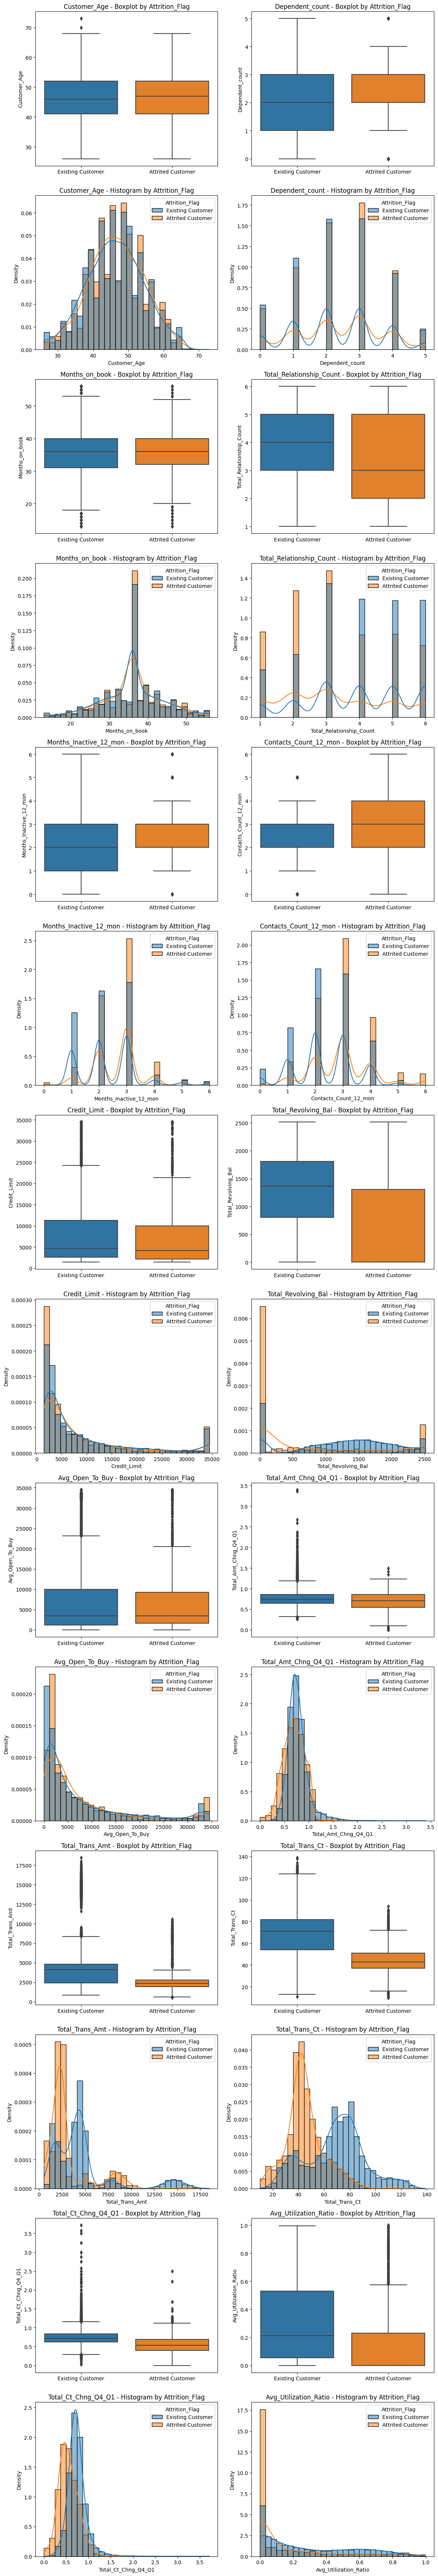

In [26]:
plot_box_and_hist_per_feature(data, hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

#### 📊 Churn Insights by Numerical Feature (Grouped by Predictive Strength)

##### ✅ Strong Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Total_Trans_Ct             | Low transaction count (<60)          | Strong predictor — low activity = high churn              |
| Total_Trans_Amt            | Low transaction amount (<5000)       | Lower spending = disengagement → higher churn             |
| Total_Ct_Chng_Q4_Q1        | Low change in transaction count      | No growth in behavior may signal disengagement            |
| Months_Inactive_12_mon     | Higher inactivity (3–4 months)       | Very strong churn indicator — inactivity is a red flag     |

##### 🟡 Moderate Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Avg_Utilization_Ratio      | Low utilization (≤0.2)               | Underutilization may imply lack of need or interest       |
| Credit_Limit               | Low credit limit (<5000)             | Lower trust or fewer incentives to stay                   |
| Avg_Open_To_Buy            | Low open-to-buy (<5000)              | Mirrors credit limit pattern — less flexibility → churn   |
| Total_Relationship_Count   | Fewer relationships (1–2)            | Customers with fewer products are more likely to leave    |
| Months_on_book             | Longer tenure (>40 months)           | Long-timers might leave due to fatigue or better offers   |

##### ❌ Weak Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Customer_Age               | Slightly older (50+)                 | Weak signal — minor shift toward older customers          |
| Dependent_count            | No clear pattern                     | Weak predictor — distribution nearly identical            |

### Categorical features - Bax and Bar Plots

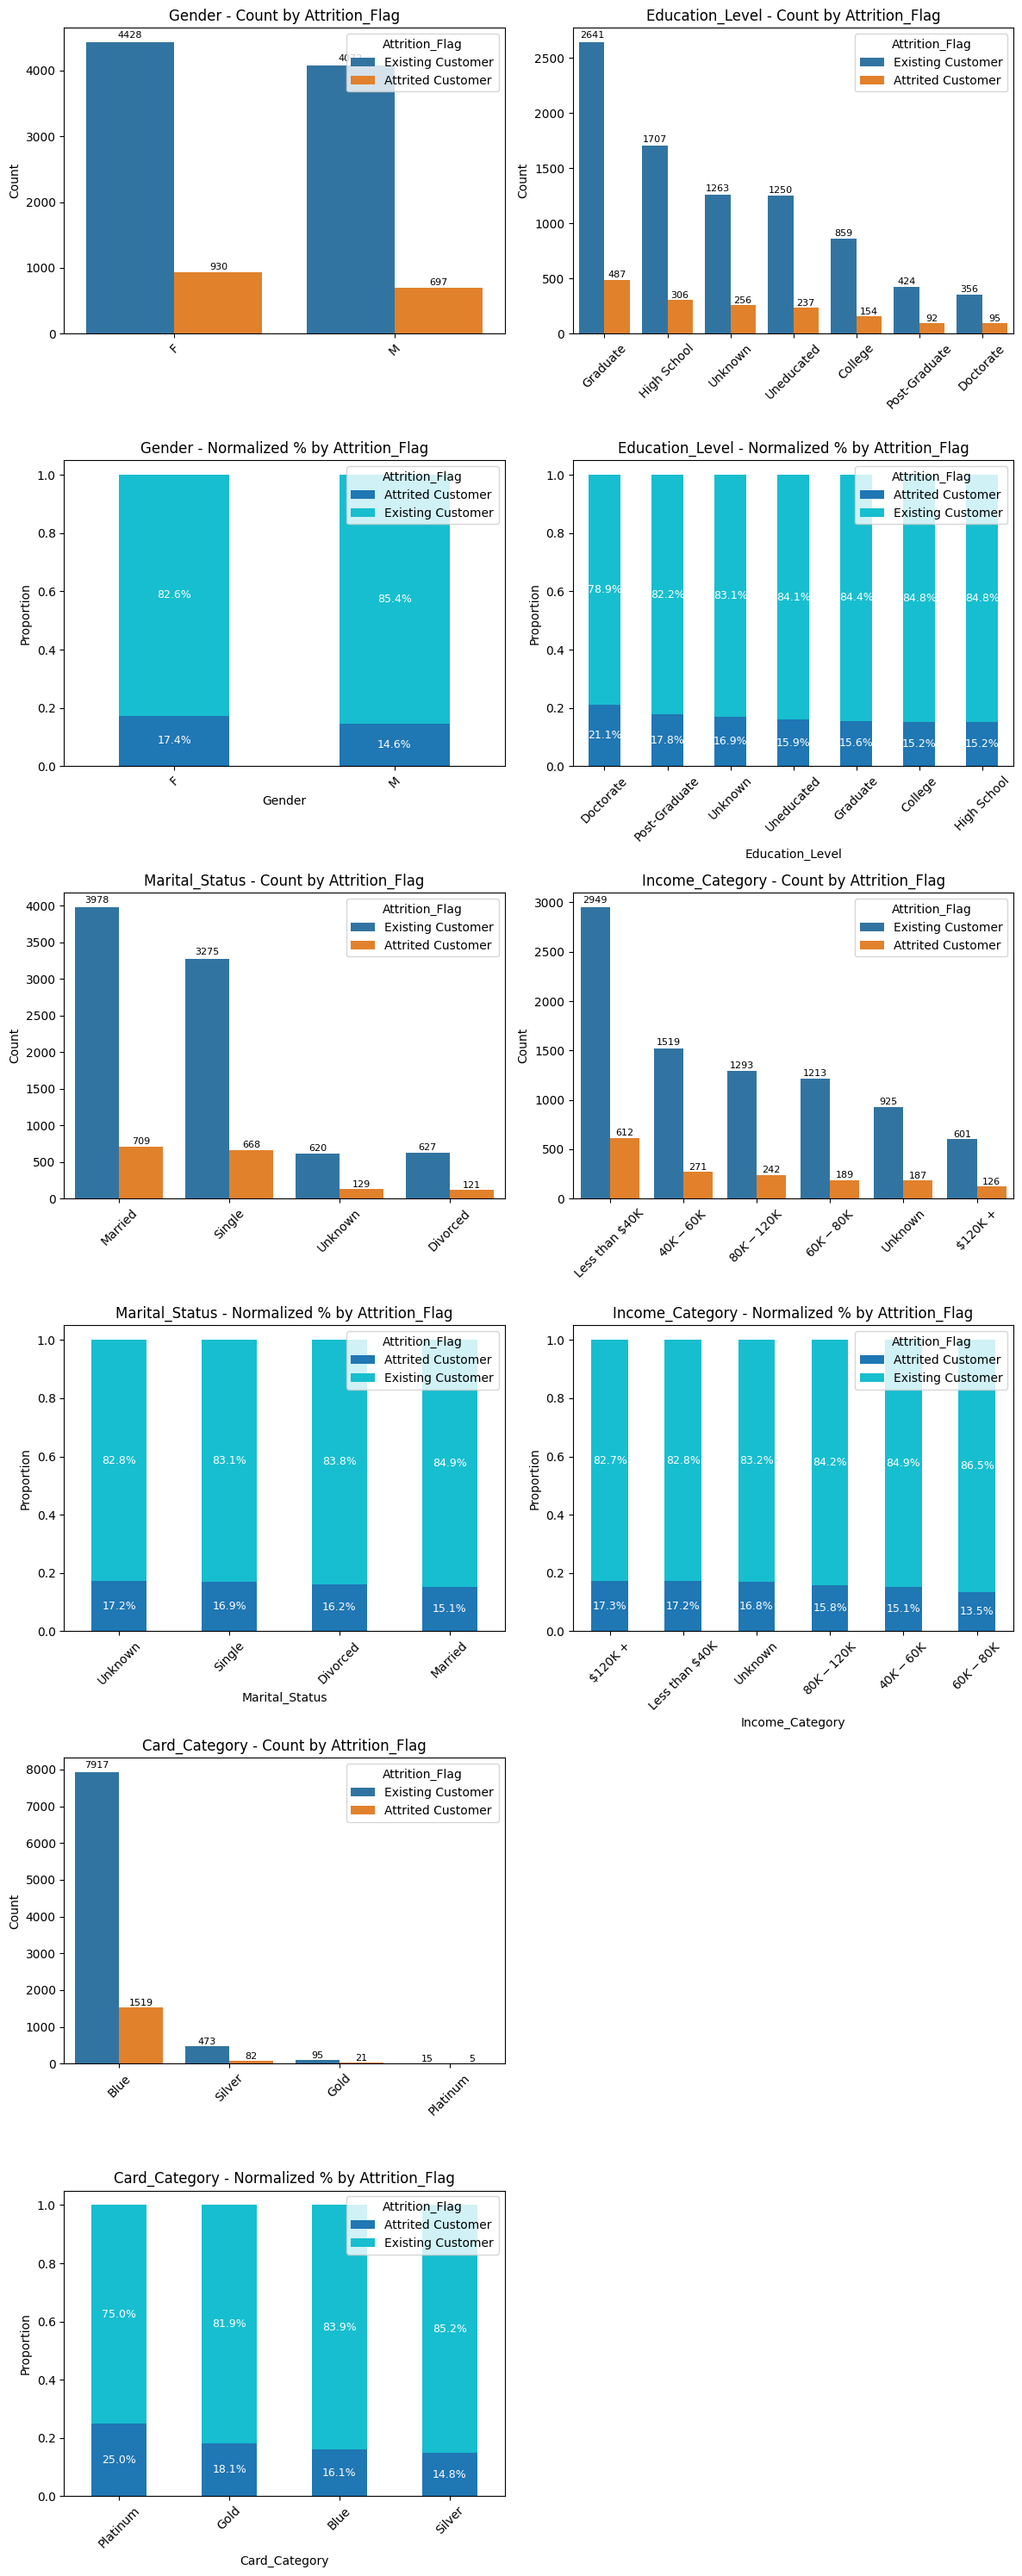

In [27]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
cat_norm_cols = [col for col in cat_cols if col != 'Attrition_Flag']
plot_bar_and_normalized_bars(data, cat_cols = cat_norm_cols, target_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True)

#### 📊 Categorical Churn Insights

| Feature         | Insights                                                              | Reasoning                                                                 |
|-----------------|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Card Category   | 🔍 Modeling: Use **Platinum** (25% churn rate)<br>📊 Business: Focus on **Blue** (high volume) | Platinum has highest churn %; Blue has most actual churners               |
| Education       | 🔍 Modeling: Flag **Doctorate** (21.1%)<br>📊 Business: Monitor **Graduate** & **High School** | Doctorate churns more; larger volume comes from mid-education groups      |
| Marital Status  | 🔍 Modeling: Watch **Unknown** / **Divorced**<br>📊 Business: Focus on **Single** / **Married** | Unknown has highest churn %, but most churn cases are from larger groups (*Married* and *Single*)  |
| Income Category | 🔍 Modeling: Use **Unknown**, **<40K** and **>$120K** as high risk<br>📊 Business: Retain **$60K–$80K**       | Churn rate is higher at extremes; stable middle-income is large & loyal   |
| Gender          | ❌ Not useful for modeling or targeting                                                  | Very small difference in churn % between Female and Male                  |

## Correlation

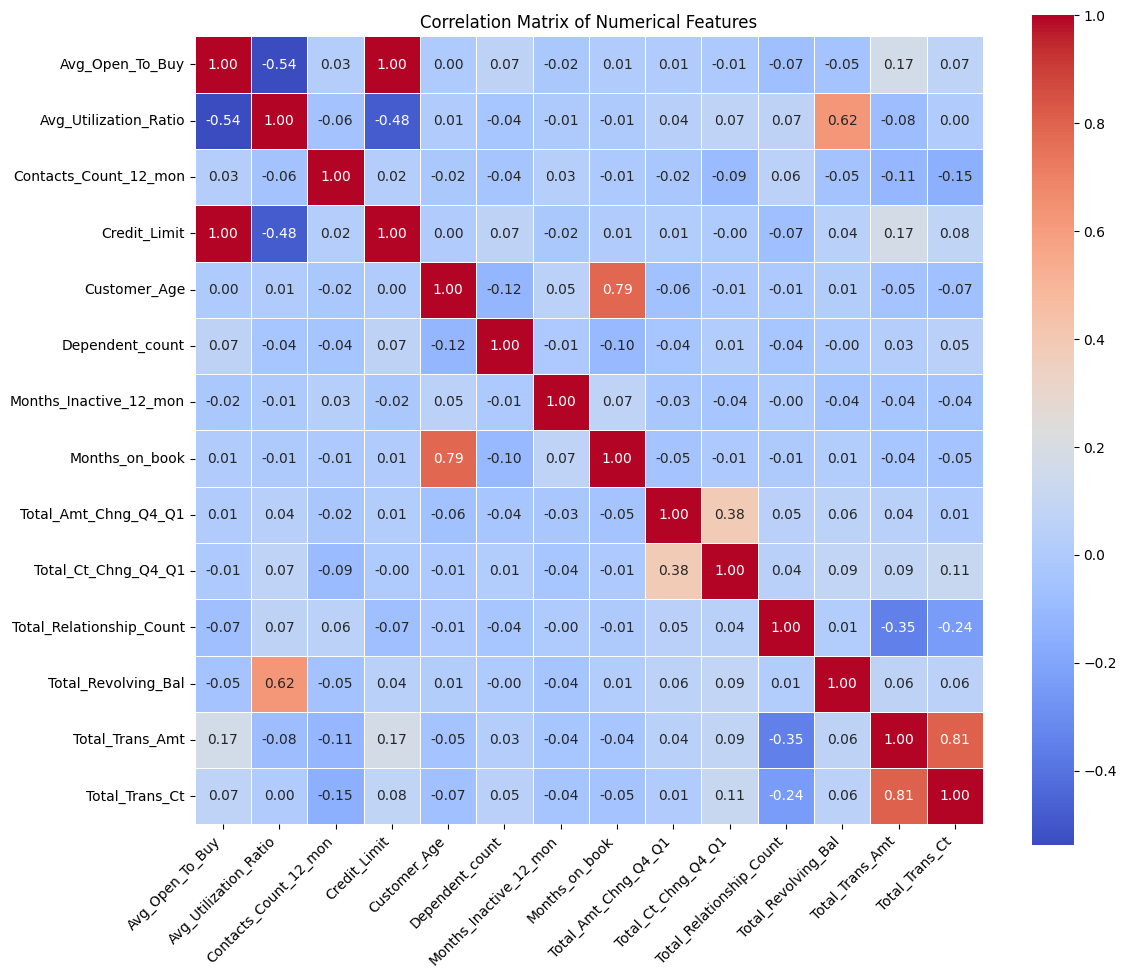

In [28]:
## columns are sorted by name
plot_corr_heat_map(data.reindex(sorted(data.columns), axis=1), figsize=(12, 10))

### 📊 Key Observations from the Correlation Matrix

#### Strong Correlation Pairs (|r| ≥ 0.7)

| Feature 1           | Feature 2           | Correlation | Notes                                              |
|---------------------|---------------------|-------------|----------------------------------------------------|
| Total_Trans_Ct      | Total_Trans_Amt     | **0.81**    | High transaction count drives higher spend         |
| Credit_Limit        | Avg_Open_To_Buy     | **1.00**    | Near-perfect correlation (could be redundant)      |
| Customer_Age        | Months_on_book      | **0.79**    | Older customers tend to have longer tenure         |

---

#### Moderate Correlation Pairs (0.3 ≤ |r| < 0.7)

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Total_Revolving_Bal    | **0.62**    | Higher balance increases utilization                     |
| Total_Amt_Chng_Q4_Q1    | Total_Ct_Chng_Q4_Q1    | **0.38**    | Changes in transaction amount align with count changes   |
| Total_Trans_Ct          | Total_Ct_Chng_Q4_Q1    | **0.35**    | Moderate correlation in behavioral activity              |

---

#### Negative Correlations to Watch

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Avg_Open_To_Buy        | **-0.54**   | Higher utilization means less open credit                |
| Avg_Utilization_Ratio   | Credit_Limit           | **-0.48**   | Larger credit limits reduce utilization ratio            |
| Total_Trans_Ct          | Total_Relationship_Count | **-0.24** | Slight inverse — possibly due to product usage patterns  |


* For highly correlated features, we need to select one to avoid multicollinearity in logistic regression. 
* However, this redundancy may not need to be addressed when using tree-based models.

# Modeling

## Logistic Regression

* Logistic Regression with L1/L2/ElasticNet
* OneHotEncoder for categorical features
* StandardScaler for numerical features
* Hyperparameter tuning with GridSearchCV
* Final test evaluationGrid

✅ handle_unknown="ignore" in OneHotEncoder ensures the model won’t crash on unseen categories during test.

In [55]:
search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols = train_logreg_pipeline(data)

Best parameters: {'logreg__C': 0.16949768237884727, 'logreg__penalty': 'l1'}
Best CV ROC AUC: 0.9249164921721121

Test ROC AUC: 0.9161145027811695
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1701
           1       0.78      0.53      0.63       325

    accuracy                           0.90      2026
   macro avg       0.85      0.75      0.78      2026
weighted avg       0.89      0.90      0.89      2026



# Evaluation

## Get best model

In [58]:
best_model, coef, all_feature_names = get_best_model(search, cat_cols, num_cols)

## Plot Metrics


🔍 Top Logistic Regression Coefficients:

                        Feature  Coefficient
0                Total_Trans_Ct    -2.633226
1               Total_Trans_Amt     1.477974
2      Total_Relationship_Count    -0.731288
3           Total_Revolving_Bal    -0.719409
4           Total_Ct_Chng_Q4_Q1    -0.663370
5                      Gender_M    -0.636745
6         Contacts_Count_12_mon     0.546246
7        Months_Inactive_12_mon     0.500190
8        Marital_Status_Married    -0.447845
9               Dependent_count     0.224536
10      Income_Category_$120K +     0.185424
11           Card_Category_Blue    -0.159701
12  Income_Category_$40K - $60K    -0.115009
13     Education_Level_Graduate    -0.086294
14         Total_Amt_Chng_Q4_Q1    -0.077524
15        Marital_Status_Single     0.071748
16        Avg_Utilization_Ratio    -0.065565
17                 Credit_Limit    -0.063233
18               Months_on_book    -0.057375
19  Income_Category_$60K - $80K    -0.049225

📊 Plotting t

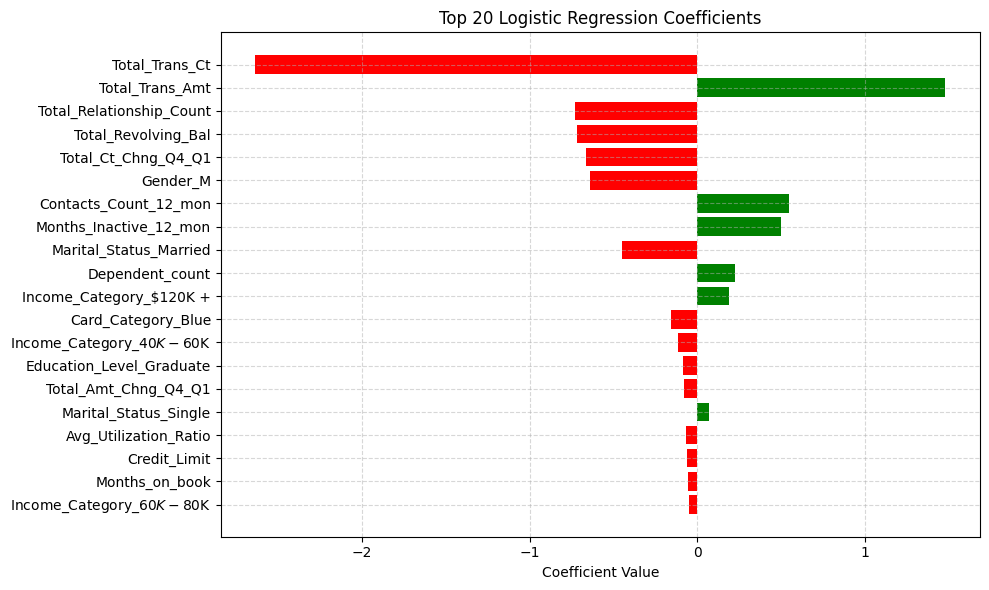


📊 Plotting Confusion Matrix...


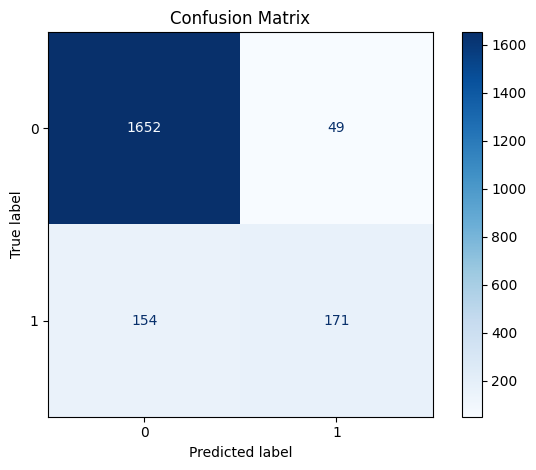

✅ Accuracy:  0.900
✅ Precision: 0.777
✅ Recall:    0.526
✅ F1 Score:  0.628

📊 Plotting ROC Curve...


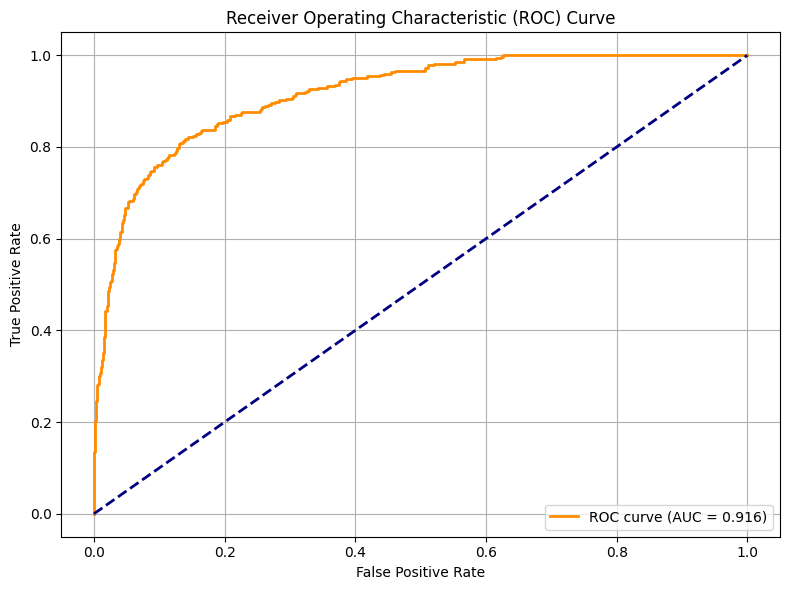


📊 Plotting Precision-Recall Curve...


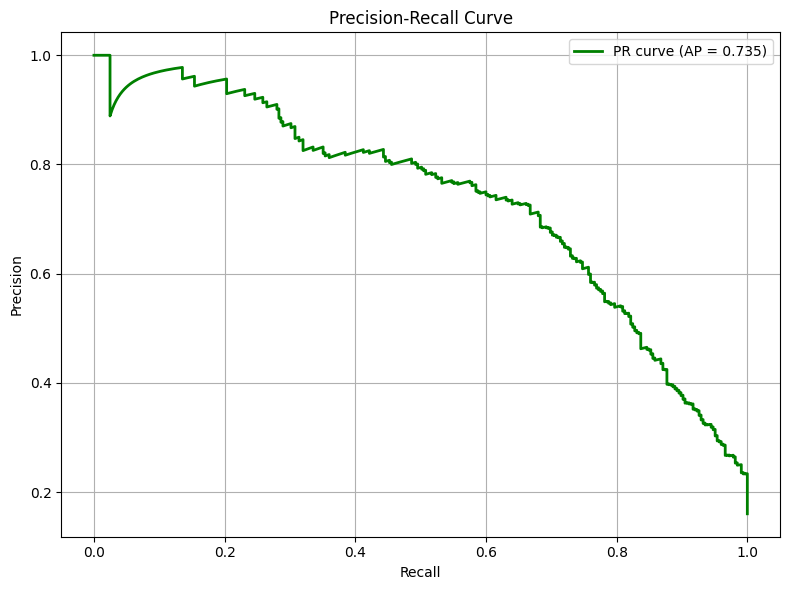

In [64]:
plot_metrics(y_test, y_pred, y_proba, coef, best_model, all_feature_names, top_n=20)

## Summary

## 📌 Feature Importance Interpretation (Logistic Regression Coefficients)

The logistic regression model identifies several key features influencing customer churn:

| Feature                  | Coefficient | Importance & Interpretation                                                    |
|--------------------------|-------------|--------------------------------------------------------------------------------|
| Total_Trans_Ct           |  -2.48      | **Most important**: More transactions sharply decrease churn risk.              |
| Total_Trans_Amt          |  +1.35      | Higher total spend **increases** churn risk (possible effect of multicollinearity). |
| Total_Revolving_Bal      |  -0.72      | Higher balance reduces churn risk.                                              |
| Total_Relationship_Count |  -0.71      | More products held = less likely to churn.                                      |
| Total_Ct_Chng_Q4_Q1      |  -0.65      | More growth in transaction count lowers churn risk.                             |
| Gender_M                 |  -0.57      | Male customers are less likely to churn (vs. female).                           |
| Contacts_Count_12_mon    |  +0.52      | More contacts with provider increase churn risk (may indicate complaints).       |
| Months_Inactive_12_mon   |  +0.47      | More inactivity months = greater churn risk.                                    |
| Marital_Status_Married   |  -0.39      | Married customers are less likely to churn.                                     |
| Dependent_count          |  +0.20      | More dependents slightly increase churn risk.                                   |

**Notes:**
- **Positive coefficients** (e.g., Total_Trans_Amt) **increase** churn risk.
- **Negative coefficients** (e.g., Total_Trans_Ct) **decrease** churn risk.
- Features with a coefficient of **0** (such as `Credit_Limit` and `Avg_Open_To_Buy`) were not used by the model. This typically happens when those features are highly correlated with other variables or do not contribute additional predictive power after accounting for the other features already in the model.

**In summary:**  
> “Transaction behavior, engagement level, and product relationships are the strongest drivers of churn risk in our model. Demographics and redundant features are less informative.”

## Visualization

### ROC Curve

* AUC = 0.916
* Model has a 91.6% chance to rank a random churner above a random non-churner.

### Precision-Recall Curve

* AP (Average Precision) = 0.735
* On average, when model says “churn,” it’s right about 73.5% of the time, while finding a good portion of actual churn cases.
* An AP of 0.735 is strong for churn, where random guessing would give us an AP close to the positive class prevalence (0.16 for churn rates in this dataset).

✅ **Overall performance**
* This model can distinguish churners from non-churners very well.
* The precision is high across a wide range of recall.

# 🔎 Insights

## 1. What behaviors indicate risk?

- **Transaction activity:** Customers with a <span style="color:red">**low**</span> number of transactions (`Total_Trans_Ct`) or <span style="color:red">**high**</span> transaction amounts (`Total_Trans_Amt`) are much more likely to churn.
- **Recent declines in activity:** A drop in transaction count or amount between quarters (`Total_Ct_Chng_Q4_Q1`, `Total_Amt_Chng_Q4_Q1`) is a strong churn signal.
- **High inactivity:** More inactive months in the last year (`Months_Inactive_12_mon`) is closely associated with attrition.
- **Few products/relationships:** Customers with fewer products (`Total_Relationship_Count`) are at higher risk.
- **Frequent contact:** Customers who contacted support frequently (`Contacts_Count_12_mon`) are also at higher churn risk—may signal dissatisfaction.
- **Demographic flags:** Certain demographic or product categories (e.g., Platinum cardholders, Doctorate degree holders) are more likely to churn, but these effects are smaller than behavioral factors.

## 2. What actions can a business take?

- **Engage low-activity customers:** Target customers showing decreased or low activity with personalized offers or communications to re-engage them.
- **Reward loyalty:** Provide incentives or rewards to customers with multiple products to reinforce loyalty and encourage product bundling.
- **Proactive outreach:** For customers with increasing inactivity or frequent contacts, conduct proactive customer service checks or surveys to resolve issues before they churn.
- **Special attention to high-risk segments:** Design targeted retention campaigns for groups with high churn rates (e.g., Platinum cardholders, Doctorate holders), even if the total number is small.
- **Monitor for early signs:** Set up automated alerts when a customer’s activity drops sharply or inactivity rises, allowing intervention before the decision to leave is finalized.

---

**In summary:**  
> The main behaviors that signal churn risk are declining and low transaction activity, increasing inactivity, frequent support contact, and having few products. The business should prioritize proactive, personalized outreach and loyalty programs for these segments to reduce churn.

# Model Optimization

## Feature Engineering

After reviewing the features using histograms and box plots, we can apply a log transformation to see if it improves model performance.

| Feature                  | Log Transform? | Why                                         |
|--------------------------|:-------------:|---------------------------------------------|
| Credit_Limit             | ✅             | Heavily right-skewed, wide numeric range    |
| Total_Revolving_Bal      | ✅             | Strong right skew, many small, few large    |
| Avg_Open_To_Buy          | ✅             | Mirrors Credit_Limit                        |
| Total_Trans_Amt          | ✅             | Right skew, wide range                      |
| Total_Trans_Ct           | ✅             | Right skew, wide range                      |
| Others                   | ❌             | No strong skew, discrete, or bounded        |


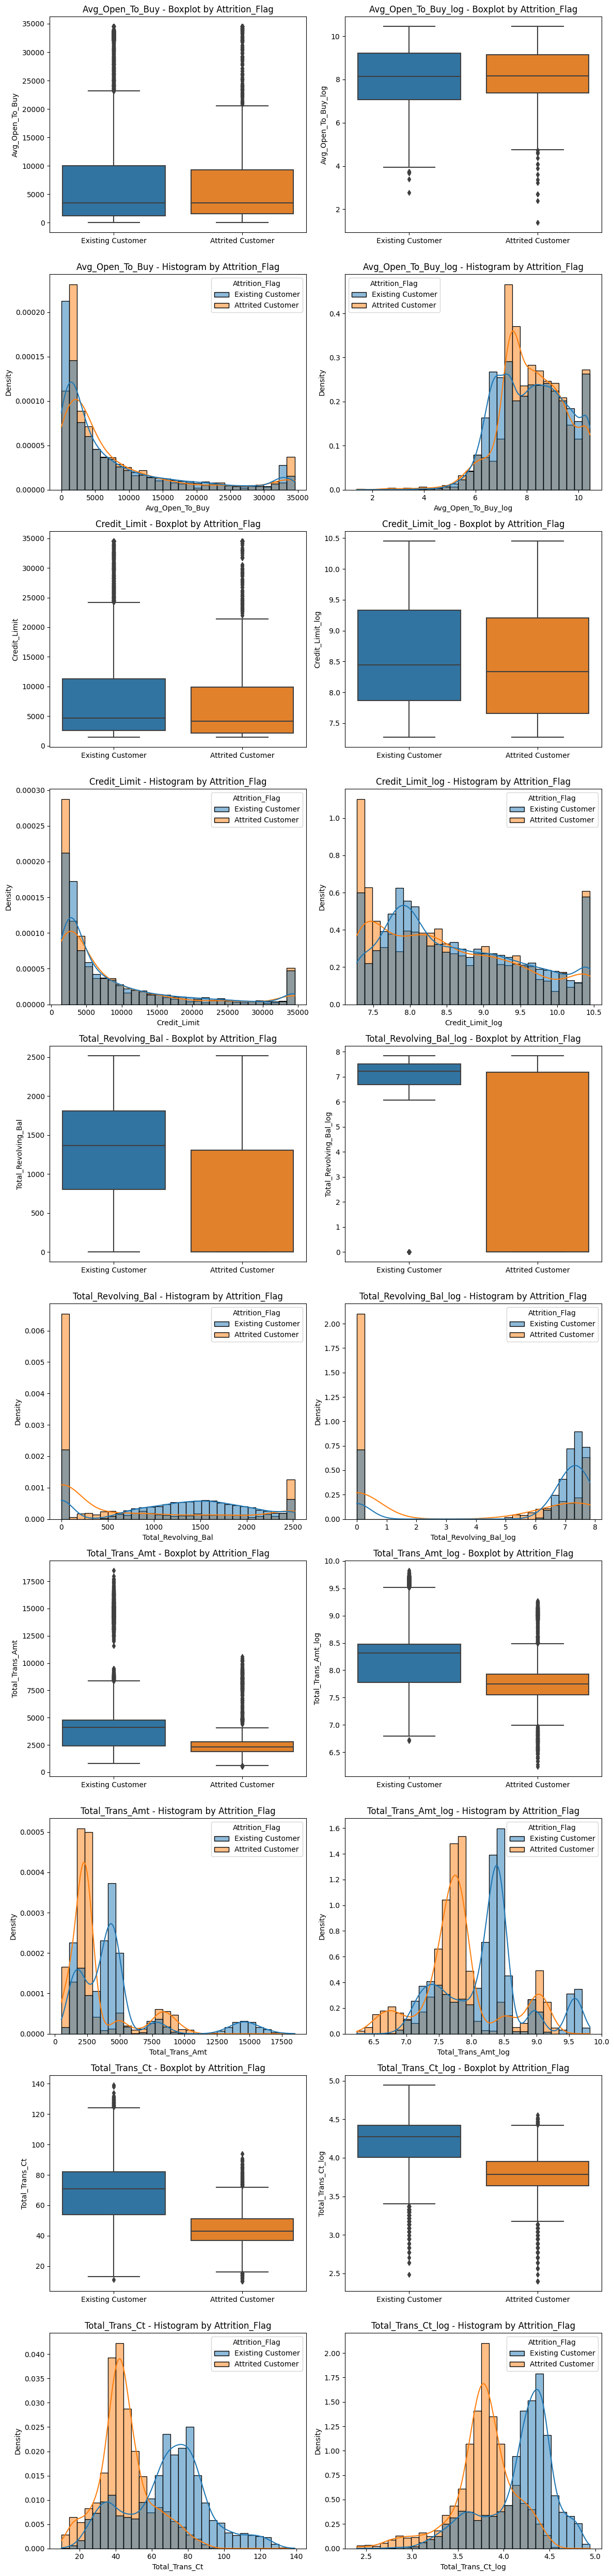

In [68]:
## log transformation
log_features = [
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Trans_Amt',
    'Total_Trans_Ct'
]

data_log = data.copy()


data_log[[f + '_log' for f in log_features]] = data_log[log_features].apply(np.log1p)

## compare features pre- and after log

compare_log_features = ['Attrition_Flag'] + log_features + [col for col in data_log.columns if col.endswith('_log')]

compare_log_features = sorted(compare_log_features)

# Plot log-transformed features
plot_box_and_hist_per_feature(data_log[compare_log_features], hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

✅ After log:
* Histograms look more bell-shaped (closer to normal).
* Boxplots show reduced effect of outliers.
* In several features, the difference between churned and non-churned groups is more interpretable (and easier for a linear model to “see”).


## Correlation heat map


📊 Plotting Correlation Matrix of Numerical Features...


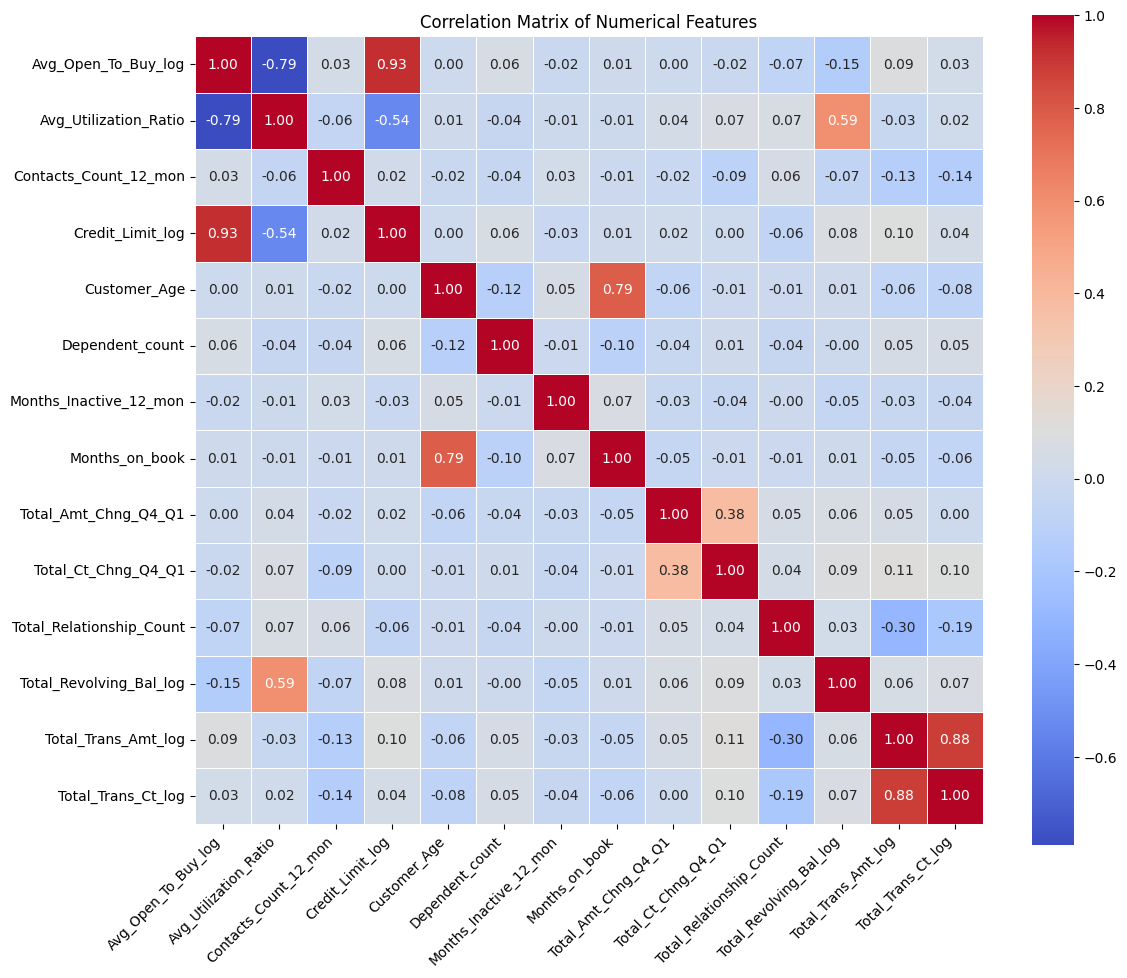

In [69]:
## get all features: log-transformed and original without those which are log-transformed
all_features = [col for col in data.columns if col not in log_features] + [col + '_log' for col in log_features]

## plot correlation matrix
plot_corr_heat_map(data_log[all_features].reindex(sorted(data_log[all_features].columns), axis=1), figsize=(12, 10))

### Log Transformation & Correlation Analysis

After applying log transformation to right-skewed features, the overall structure of feature correlations remains similar. This is expected, as Pearson correlation measures linear associations, and monotonic log transforms typically preserve the order of values. Highly correlated feature pairs before log (e.g., `Credit_Limit` & `Avg_Open_To_Buy`) remain highly correlated after log transformation.

Log transformation, however, does make distributions more normal and models more stable—even if correlations do not change dramatically.

# Retrain the model with log-transformed features

In [70]:
## Split train and test data
data_new = data_log[all_features]

search_new, X_test_new, y_test_new, y_pred_new, y_proba_new, cat_cols_new, num_cols_new = train_logreg_pipeline(data=data_new)

Best parameters: {'logreg__C': 0.19780827689353772, 'logreg__penalty': 'l1'}
Best CV ROC AUC: 0.9235103878733908

Test ROC AUC: 0.9154379776601999
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1701
           1       0.81      0.55      0.66       325

    accuracy                           0.91      2026
   macro avg       0.86      0.76      0.80      2026
weighted avg       0.90      0.91      0.90      2026



## Getting best model

In [71]:
best_model_new, coef_new, all_feature_names_new = get_best_model(search_new, cat_cols_new, num_cols_new)

## New evaluation


🔍 Top Logistic Regression Coefficients:

                         Feature  Coefficient
0             Total_Trans_Ct_log    -2.567723
1            Total_Trans_Amt_log     1.579840
2        Total_Revolving_Bal_log    -0.816599
3            Total_Ct_Chng_Q4_Q1    -0.809162
4       Total_Relationship_Count    -0.653096
5          Contacts_Count_12_mon     0.600344
6                       Gender_M    -0.553841
7         Months_Inactive_12_mon     0.504637
8            Avg_Open_To_Buy_log    -0.360794
9         Marital_Status_Married    -0.347567
10       Income_Category_$120K +     0.294678
11               Dependent_count     0.201154
12            Card_Category_Blue    -0.200181
13              Credit_Limit_log     0.149363
14         Avg_Utilization_Ratio    -0.132400
15          Total_Amt_Chng_Q4_Q1    -0.128155
16  Income_Category_$80K - $120K     0.122181
17   Income_Category_$40K - $60K    -0.080598
18      Education_Level_Graduate    -0.078481
19     Education_Level_Doctorate     0

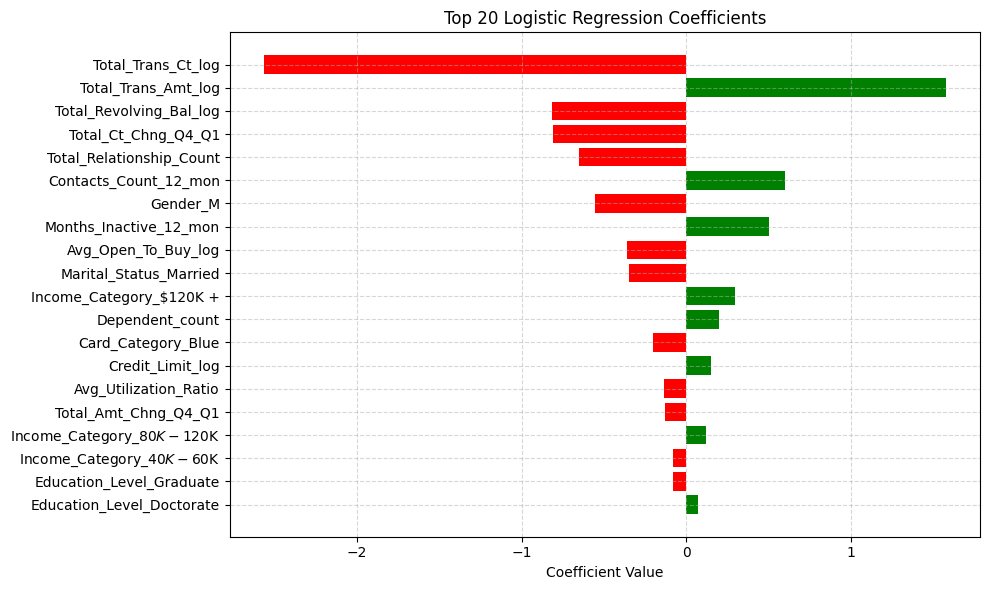


📊 Plotting Confusion Matrix...


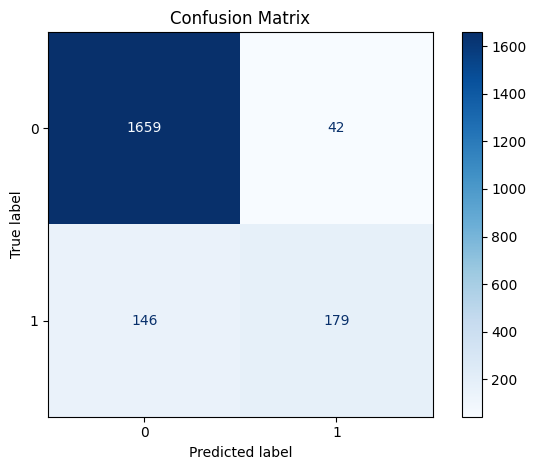

✅ Accuracy:  0.907
✅ Precision: 0.810
✅ Recall:    0.551
✅ F1 Score:  0.656

📊 Plotting ROC Curve...


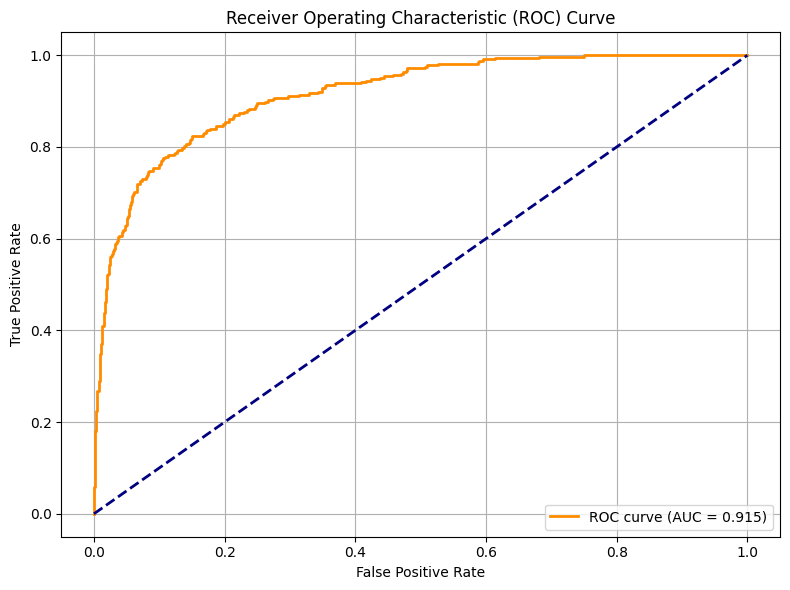


📊 Plotting Precision-Recall Curve...


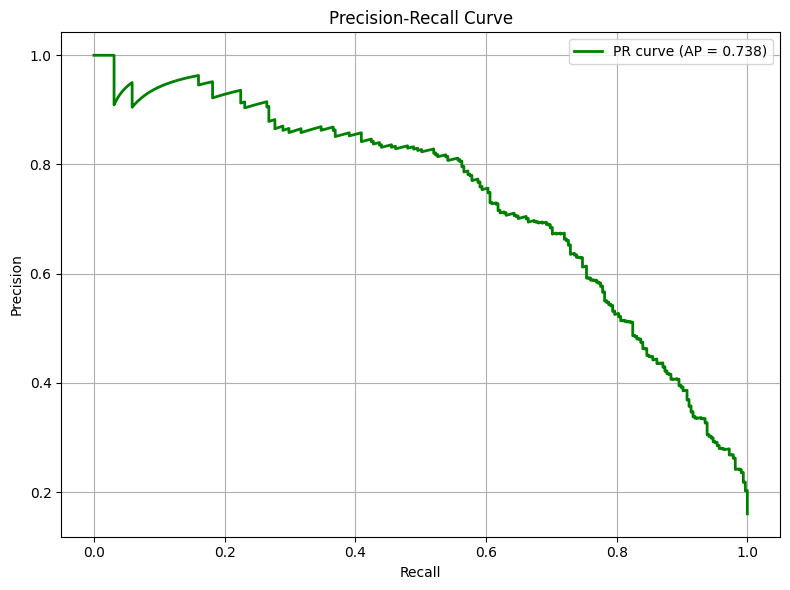

In [72]:
plot_metrics(y_test, y_pred_new, y_proba_new, coef_new, best_model_new, all_feature_names_new, top_n=20)

### Summary
* The model performance increased slightly but not significantly (Identifying more churn customers while reducing false predicted churn customers). We also noticed that some of the important features changed.
* Next, we can try another approach. Since the target is imbalanced, we can apply SMOTE to oversample the minority class and see if exposing the model to more balanced data improves its performance.

# SMOTE

## Without log transformation

In [76]:
search_smote, X_test_smote, y_test_smote, y_pred_smote, y_proba_smote, cat_cols_smote, num_cols_smote = train_logreg_pipeline_with_smote(data)

Best parameters: {'logreg__C': 0.03334792728637584, 'logreg__l1_ratio': 1.0, 'logreg__penalty': 'elasticnet'}
Best CV ROC AUC: 0.9259900148562432

Test ROC AUC: 0.9190828924162258
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1701
           1       0.54      0.80      0.64       325

    accuracy                           0.86      2026
   macro avg       0.75      0.83      0.78      2026
weighted avg       0.89      0.86      0.87      2026




🔍 Top Logistic Regression Coefficients:

                           Feature  Coefficient
0                   Total_Trans_Ct    -2.924355
1                  Total_Trans_Amt     1.656135
2              Total_Ct_Chng_Q4_Q1    -0.688195
3         Total_Relationship_Count    -0.651646
4              Total_Revolving_Bal    -0.603381
5            Contacts_Count_12_mon     0.572633
6                         Gender_M    -0.567967
7           Months_Inactive_12_mon     0.548807
8           Marital_Status_Married    -0.233085
9                  Dependent_count     0.229338
10           Marital_Status_Single     0.182867
11           Avg_Utilization_Ratio    -0.120985
12  Income_Category_Less than $40K     0.120523
13                  Months_on_book    -0.098317
14            Total_Amt_Chng_Q4_Q1    -0.094888
15        Education_Level_Graduate    -0.012353
16     Income_Category_$60K - $80K    -0.002644
17     Income_Category_$40K - $60K    -0.002147
18              Card_Category_Gold     0.00000

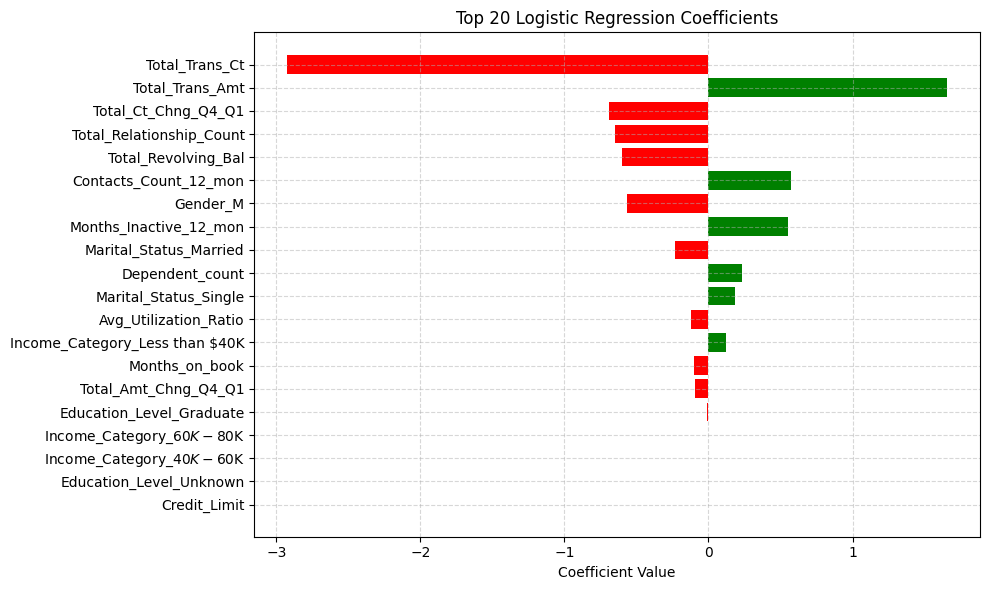


📊 Plotting Confusion Matrix...


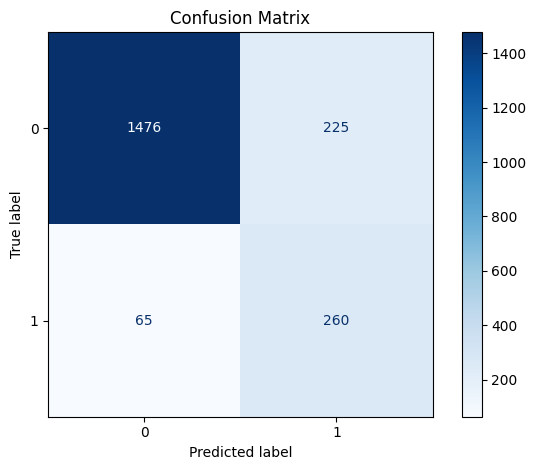

✅ Accuracy:  0.857
✅ Precision: 0.536
✅ Recall:    0.800
✅ F1 Score:  0.642

📊 Plotting ROC Curve...


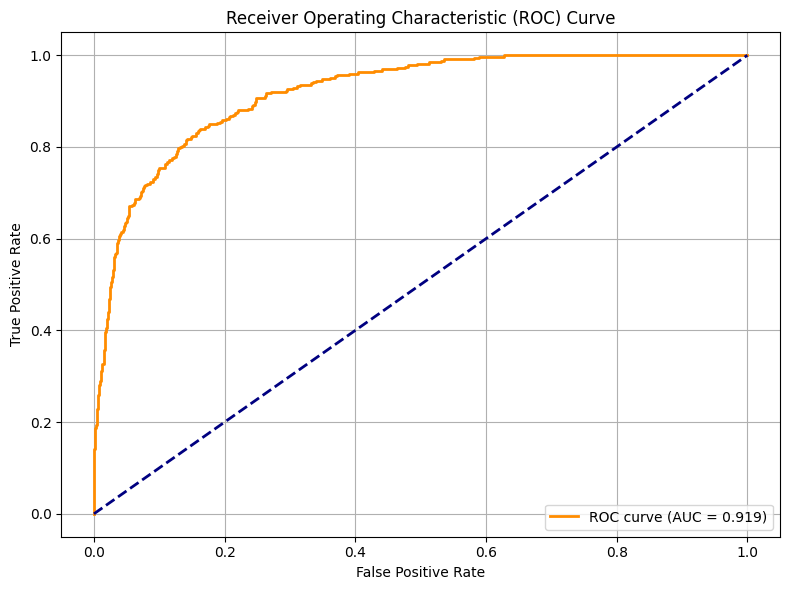


📊 Plotting Precision-Recall Curve...


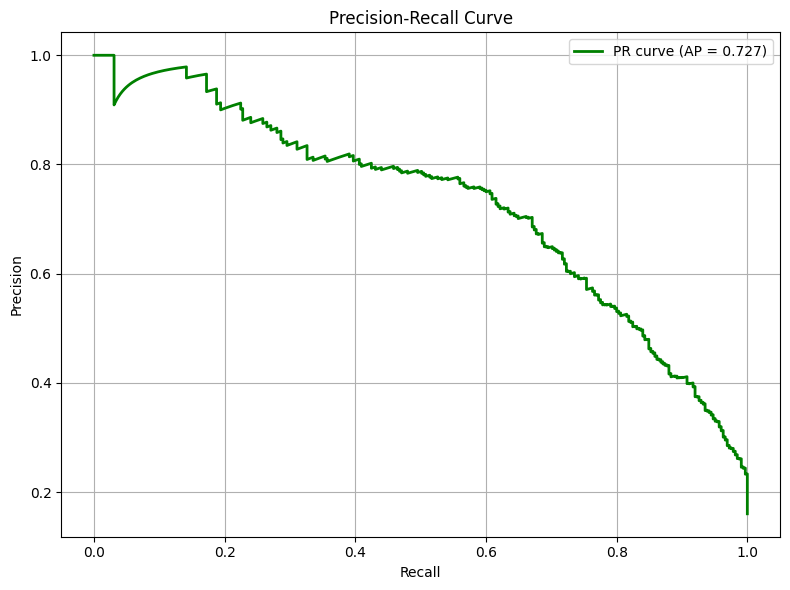

In [77]:
## get best model
best_model_smote, coef_smote, all_feature_names_smote = get_best_model(search_smote, cat_cols_smote, num_cols_smote)
plot_metrics(y_test_smote, y_pred_smote, y_proba_smote, coef_smote, best_model_smote, all_feature_names_smote, top_n=20)


## With log transformation

Best parameters: {'logreg__C': 0.03334792728637584, 'logreg__l1_ratio': 1.0, 'logreg__penalty': 'elasticnet'}
Best CV ROC AUC: 0.9253858646387891

Test ROC AUC: 0.9182634649301317
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1701
           1       0.54      0.79      0.64       325

    accuracy                           0.86      2026
   macro avg       0.75      0.83      0.78      2026
weighted avg       0.89      0.86      0.87      2026


🔍 Top Logistic Regression Coefficients:

                         Feature  Coefficient
0             Total_Trans_Ct_log    -2.971261
1            Total_Trans_Amt_log     1.794595
2            Total_Ct_Chng_Q4_Q1    -0.826528
3        Total_Revolving_Bal_log    -0.800323
4          Contacts_Count_12_mon     0.632379
5         Months_Inactive_12_mon     0.563832
6       Total_Relationship_Count    -0.556590
7                       Gender_M    -0.503686
8             

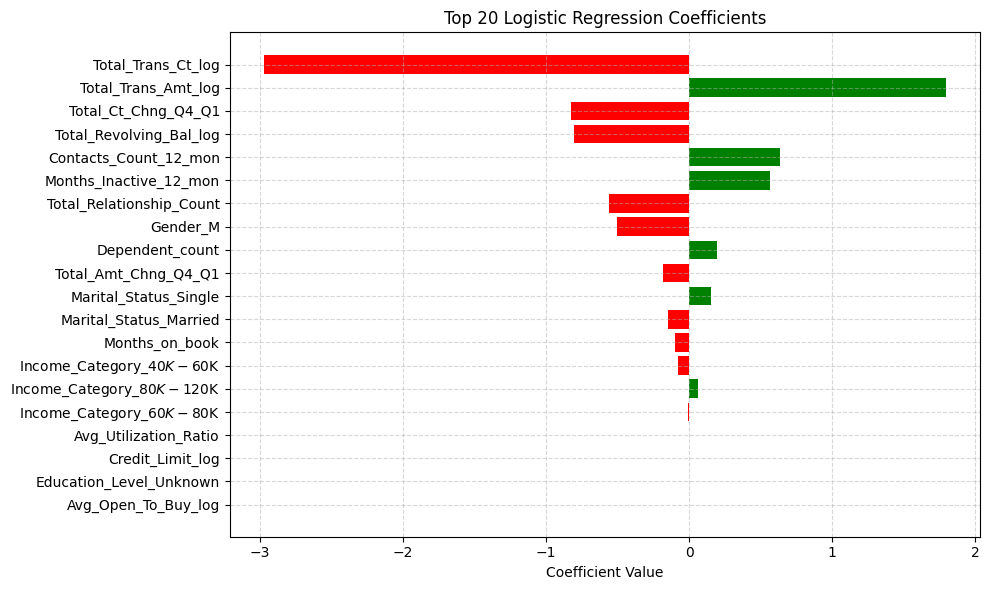


📊 Plotting Confusion Matrix...


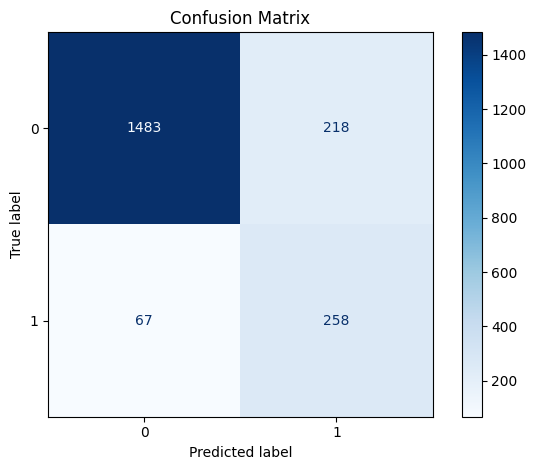

✅ Accuracy:  0.859
✅ Precision: 0.542
✅ Recall:    0.794
✅ F1 Score:  0.644

📊 Plotting ROC Curve...


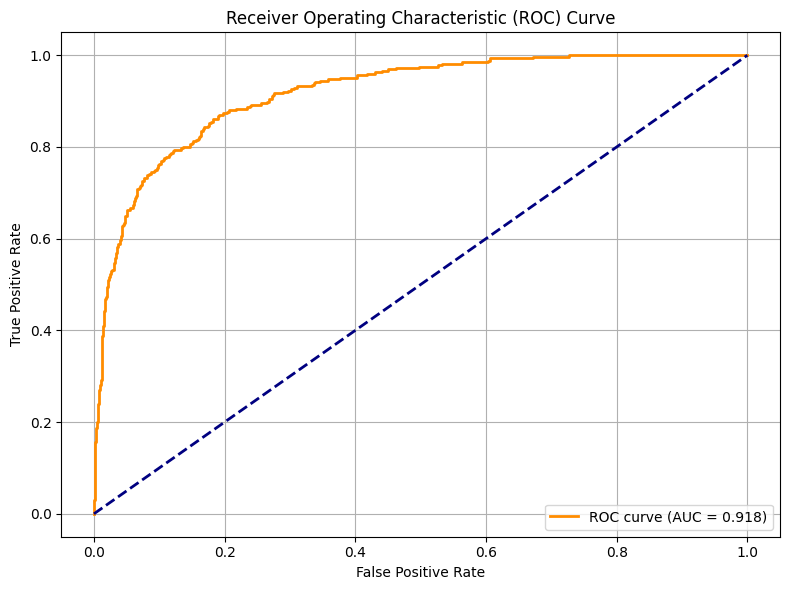


📊 Plotting Precision-Recall Curve...


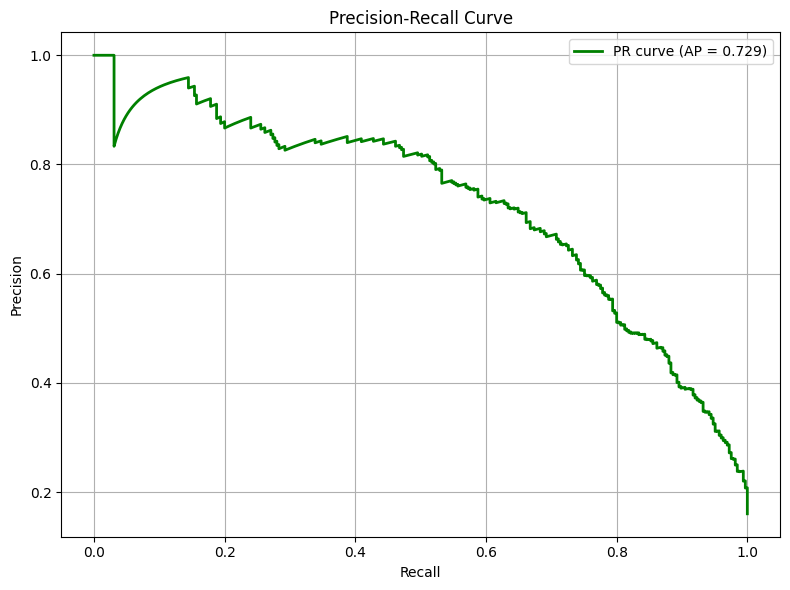

In [78]:
search_smote_log, X_test_smote_log, y_test_smote_log, y_pred_smote_log, y_proba_smote_log, cat_cols_smote_log, num_cols_smote_log = train_logreg_pipeline_with_smote(data=data_new)
## get best model
best_model_smote_log, coef_smote_log, all_feature_names_smote_log = get_best_model(search_smote_log, cat_cols_smote_log, num_cols_smote_log)
plot_metrics(y_test_smote_log, y_pred_smote_log, y_proba_smote_log, coef_smote_log, best_model_smote_log, all_feature_names_smote_log, top_n=20)

# 🧪 Model Performance Summary & Interpretation

| Version                    | ROC-AUC (Test) | Accuracy | Precision | Recall | F1 Score |
|----------------------------|:--------------:|:--------:|:---------:|:------:|:--------:|
| Regular                    |   0.9161       |  0.900   |  0.777    | 0.526  |  0.628   |
| ✅ Feature engineering      |   0.9154       |  0.907   |  0.810    | 0.551  |  0.656   |
| SMOTE                      |   0.9190       |  0.857   |  0.536    | 0.800  |  0.642   |
| Feature engineering + SMOTE|   0.9182       |  0.859   |  0.542    | 0.794  |  0.644   |

**Key Insights:**
- **Feature engineering** consistently improves model performance, leading to higher accuracy, precision, recall, and F1 compared to the baseline.
- **SMOTE** successfully increases recall (from 0.551 to ~0.800), meaning the model is better at catching churners. However, this comes at the cost of reduced precision (more false positives) and overall accuracy.
- **Combining feature engineering with SMOTE** maintains high recall, but does not improve precision or overall model performance beyond what feature engineering alone achieves.
- **ROC-AUC remains very high** for all models, indicating strong overall discrimination between churners and non-churners.

**Conclusion:**  
> While SMOTE improves recall for the minority (churn) class, it does not enhance overall model performance and may introduce more false positives. Feature engineering yields the best balance of performance metrics for this dataset.

**Final thought:**
> For real-world deployment, we should consider business priorities: If we must catch every churner (even with more false alarms), SMOTE is helpful. If we want to balance cost of outreach, stick to feature engineering.